In [1]:
## Importing Qiskit libraries
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
import numpy as np

In [2]:
## Settings
d = 1 # dimension
M = 2 # number of particles
L = 2 # number of qubits for momentum
N = L * d + d + 1 # nummber of qubits per one particle
delta = 0.1

In [3]:
def init(M): # initialize circuit
    particle_registers = []
    for i in range(M):
        particle_registers.append(QuantumRegister((L + 1) * d + 1, name = f'particle{i}'))
    particle_registers.append(QuantumRegister(L, name = f'aux')) # aux register for free Hamiltonian
    circuit = QuantumCircuit(*particle_registers)
    return circuit, particle_registers

In [23]:
#### examples of operation ####
## operate x gate to one certain qubit
# circuit.x(((L + 1) * d + 1) * M)
# circuit.h(particle_registers[1][0])

## operate x gate to one certain particle register
# circuit.x(particle_registers[0])

## operate x gate to all qubits
# for i in range(M):
#     circuit.x(particle_registers[i])

# circuit.draw('mpl') # 1つのparticleに対して下位 L* d ビットが運動量の大きさ、次のdビットが符号、最後1ビットがoccupancy

In [4]:
def addition(circuit, reg_in_list, reg_out): # reg_in is the list of registers, reg_out is qubits
    circuit.h(reg_out)
    dphi = 2. * np.pi / (2 ** reg_out.size)
    # print(reg_in_list)
    for reg_ctrl in reg_in_list: # reg_ctrl corresponds to QuantumRegister, reg_in_list to list of QuantumRegister
        for ictrl, qctrl in enumerate(reg_ctrl): # qctrl corresponds to Qubits, reg_ctrl to QuantumRegister
            for itarg, qtarg in enumerate(reg_out): # qtarg corresponds to Qubits, reg_out to QuantumRegister
                # C[P(phi)], phi = 2pi * 2^{ictrl} * 2^{itarg} / 2^{n3}
                circuit.cp(delta * dphi * (2 ** (ictrl + itarg)), qctrl, qtarg)
    circuit.h(reg_out)
    return circuit

In [5]:
def make_add_gate(M, L): # M \times L bits に対して L bitsの補助ビットを使って足し算するゲート
    reg_list = []
    for _ in range(M + 1):
        reg_list.append(QuantumRegister(L))
    circuit = QuantumCircuit(*reg_list)
    add_circuit = addition(circuit, reg_list[0:M], reg_list[M])
    add_gate = add_circuit.to_gate()
    cadd_gate = add_gate.control(1) # controlled add_gate
    return add_gate, cadd_gate

In [6]:
def set_target_list(M, L, particle_registers):
    targ_list = []
    for i in range(M+1):
        targ_list += particle_registers[i][0:L]
    return targ_list

In [141]:
# def symmetrization(circuit, particle_registers, M):
#     aux = QuantumRegister(M)
#     circuit.h(aux)
#     for i in range(N):
#         if i != 0:
#             circuit.cswap(particle_registers[i - 1], particle_registers[i], aux(i))
#         else: circuit.swap(particle_registers[M - 1], particle_registers[0], aux(i))
#     sym_gate = circuit.to_gate()
#     return sym_gate

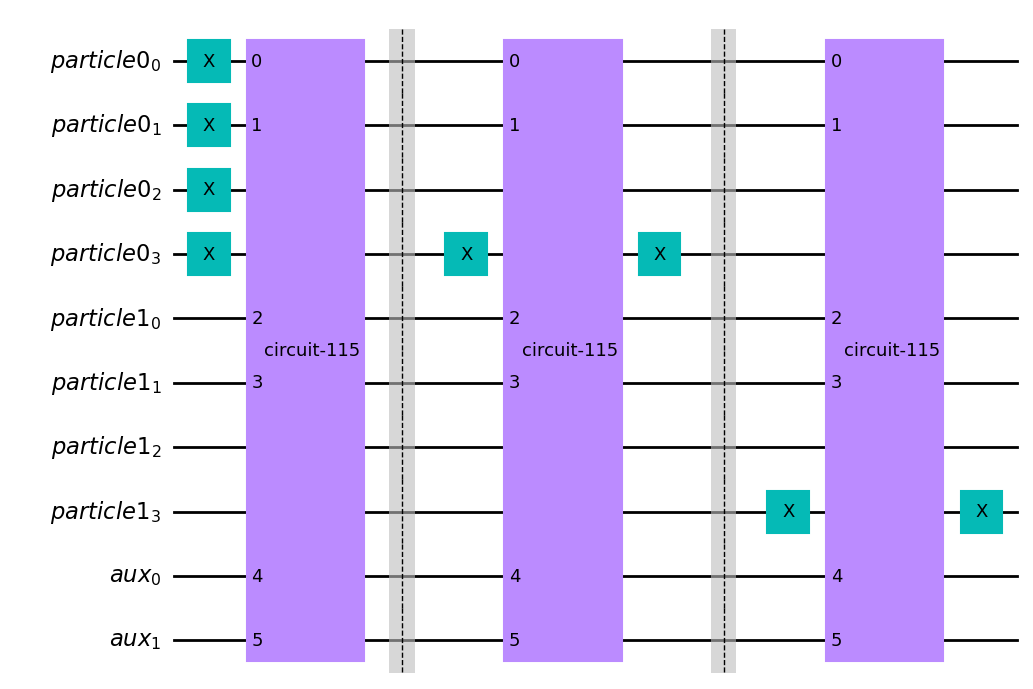

In [7]:
## main
circuit, particle_registers = init(M) # initialization

circuit.x(particle_registers[0]) # make arbitrary circuit

add_gate, cadd_gate = make_add_gate(M, L) # make addition gate
targ_list = set_target_list(M, L, particle_registers) # set target_list

circuit.append(add_gate, qargs=targ_list)
for i in range(M):
    circuit.barrier()
    circuit.x(particle_registers[i][L + d])
    circuit.append(cadd_gate, qargs=([particle_registers[i][L + d]] + targ_list)) # n_Omega times
    circuit.x(particle_registers[i][L + d])

circuit.draw('mpl')